In [1]:
# default_exp vision.cells

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Vision.cells

A collection of utilities for dealing with images of cells from microscopy.


## Cell classifiers

First, we'll look at an autoencoder using the Fast.ai framework.
I'll primarily be relying on these tutorials:

- https://alanbertl.com/autoencoder-with-fast-ai/
- https://docs.fast.ai/tutorial.vision.html

In [3]:
# export

import pandas as pd
import numpy as np
import torch
from fastai.vision.all import *
from fastai.data.all import *


First, get the files together using fast.ai `Path` objects.

In [4]:
DATA_PATH = Path('/home/will/data/ZakImages/extracted/')
fnames = get_image_files(DATA_PATH)
print(len(fnames))
fnames[:5]

#files = get_image_files(DATA_PATH)
#len(files)

660


(#5) [Path('/home/will/data/ZakImages/extracted/control_nuc216.png'),Path('/home/will/data/ZakImages/extracted/control_nuc2.png'),Path('/home/will/data/ZakImages/extracted/control_nuc18.png'),Path('/home/will/data/ZakImages/extracted/saha_nuc102.png'),Path('/home/will/data/ZakImages/extracted/saha_nuc278.png')]

Empty `DataBlock`s sit idle until passed items.

In [5]:
#export
from pathlib import PosixPath


class PILImageInt(PILImage): 
    _show_args = {'cmap':'greys'}#,{'mode': 'I'}
    @classmethod
    def create(cls, fn:(Path,str,Tensor,ndarray,bytes), **kwargs)->None:
        
        #print(type(fn))
        #raise KeyboardInterrupt
        
        if type(fn) is PosixPath:
            img = load_image(fn)
            ar = np.array(img)
            img = ((ar/65535)*255).astype(np.uint8)
            nimg = Image.fromarray(img, mode = 'L')
            nimg = nimg.convert(mode = 'RGB')
            return PILImageInt(to_image(nimg))

        else:
            return super().create(fn, **kwargs)
        
        
    def show(self, ctx=None, **kwargs):
        "Show image using `merge(self._show_args, kwargs)`"
        return show_image(self, ctx=ctx, **merge(self._show_args, kwargs))
        
        
    

In [6]:

def label_func(fname): 
    
    #print(fname)
    #raise KeyboardInterrupt
    
    return 'control' if 'control' in fname.name else 'saha'

item_tfms = [Resize(224, method='crop')]
batch_tfms=[Normalize.from_stats(*imagenet_stats), 
            *aug_transforms(size=256, flip_vert=True, max_rotate=180, 
                            pad_mode='zeros')]

dblock = DataBlock(get_items = get_image_files, # now get images on the fly from a directory
                   get_y     = label_func, # Get labels from filenames,
                   blocks    = (ImageBlock(cls = PILImageInt), CategoryBlock), #define the block types
                   item_tfms=item_tfms,
                   batch_tfms=batch_tfms,
                   splitter = RandomSplitter()
                   )
dls = dblock.dataloaders(DATA_PATH)


Mark a phenotype. In this case, use the folder structure.

When constructing the image loader you need to add _Data Augmentations_ to get the images to the same size, do flips, etc.

Refer here: https://docs.fast.ai/vision.augment.html

In [7]:
from fastai.vision.learner import *

In [15]:

head = create_head(512*2, 2, 
                   lin_first = True,
                   lin_ftrs=[1024, 256, 64])

learn = cnn_learner(dls, xresnet34, 
                    metrics=[error_rate, accuracy], 
                    custom_head=head,
                   )
#learn.fine_tune(1)

SuggestedLRs(lr_min=0.03630780577659607, lr_steep=1.5848931980144698e-06)

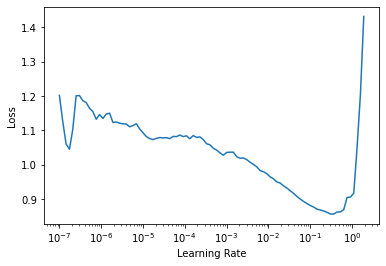

In [16]:
learn.lr_find()

In [19]:
learn.fine_tune(30, freeze_epochs = 5, base_lr = 0.01, 
                cbs = [EarlyStoppingCallback(monitor='valid_loss', patience=2)])

No improvement since epoch 0: early stopping


No improvement since epoch 3: early stopping


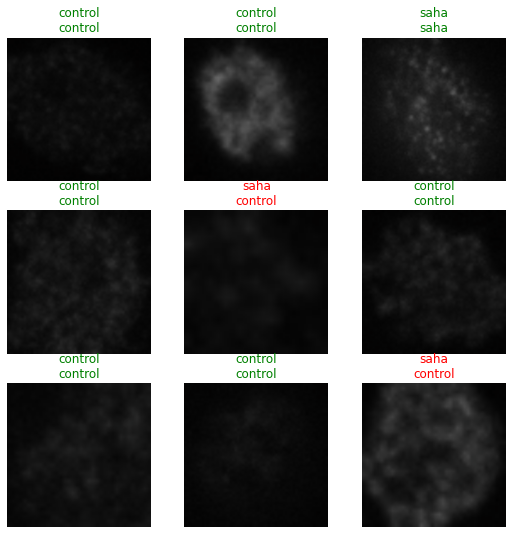

In [11]:
learn.show_results()

In [ ]:
# Adapted from: https://alanbertl.com/autoencoder-with-fast-ai/

class UpSample(nn.Module):
    def __init__(self,feat_in,feat_out,out_shape=None,scale=2):
        super().__init__()
        self.conv = ConvLayer(feat_in,feat_out,kernel_size=(3,3),stride=1,padding=1)
        self.out_shape,self.scale = out_shape,scale
        
    def forward(self,x):
        return self.conv(nn.functional.interpolate(x,
                                                   size=self.out_shape,
                                                   scale_factor=self.scale,
                                                   mode='bilinear',
                                                   align_corners=True))

# Upsampling for autoencoders.

class SimpleUpSample(nn.Sequential):
    "Create a simple CNN with `filters`."
    def __init__(self, filters, sizes, kernel_szs=None, strides=None, bn=True):
        nl = len(filters)-1
        kernel_szs = ifnone(kernel_szs, [3]*nl)
        strides    = ifnone(strides   , [2]*nl)
        layers = [UpSample(filters[i], filters[i+1], sizes[i]) for i in range(nl)]
        
        super().__init__(*layers)